In [2]:
import pymc3 as pm
import numpy as np
import pandas as pd
import arviz as az
from matplotlib import pyplot as plt

# Examples of Hierarchical Models (Chapter 9)

* **Tossing coins from different mints**, mint has a typical bias, each coin has its own concrete bias (that varies a bit between coins)
* **Baseball player abilitie**s: Each player has a success rate, a number of opportunities, and the primary position in the game. To that we add a higher layer: a typical batting ability of a player by position. (this is like a coin where every bat opportunity is a toss, every player is a coin with a certain success rate, every position is like the mint with a typical success rate for its players).
* **Success of surgery** in different hospitals by different teams:  i) the number of recoveries per team ii) the number of surgeries per team ii) the hospital city (this is like a coin, where every operation is a toss, every team is a coin, every hospital has a typical success rate).

# Single Mint Single Coin (Example #1)
* For starters let's just consider a single coin with parameter $\theta$ coming from a mint with a typical bias concentrated around $\omega$. 
* The following figure summarizes the model graphically (Fig. 9.1 in Kruschke)

![](single-mint-single-coin.png)

* The concentration $K$ is considered constant in this model for simplicity.
* The top-level distribution controls how different are the mints from each other.
* The code below presents the same model in PyMC3 (where we made $A_\omega$ and $B_\omega$ equal to 2)

In [3]:
with pm.Model() as model1:
    K = 100  # concentration, how reliable is the bias of coins produced by the mint
    omega = pm.Beta ("omega", 2,2)
    theta = pm.Beta ("theta", alpha=omega*(K-2)+1, beta=(1-omega)*(K-2)+1)
    y = pm.Bernoulli ("y", p=theta)

# Bayes Theorem (Applied to the hierarchical case)

* With hierarchical modeling we apply Bayes rule to the joint parameter space.
* This is the Bayes rule applied to the joint parameter space:

$$p (\theta,\omega \mid y) \sim p (y \mid \theta, \omega) ~ p (\theta, \omega) = p (y \mid \theta) ~ p(\theta\mid\omega) ~ p (\omega) $$

$p (y \mid \theta, \omega) => p (y \mid \theta)$ TODO

$p (\theta, \omega) => p(\theta\mid\omega)~p (\omega)$

* The second equality is important: p.219
    * If we fix $\theta$, 
    * Then the experiment result $y$ no longer depends on $\omega$
    * We can use the chain rules to factorize more conditional probabilities.  
    * This way we can avoid working with a large joint probability space.  
* Advantages of such hierarchical factorization
    * The model structure makes sense for humans (to check that it is correct and rational)
    * * Inference algorithms can exploit the decomposition (for instance Gibbs sampling will work if it can sample from each of the conditional likelihoods).

# Hierarchical Model 

**Def.** *Hierarchical Model is any model that can be factored into a chain of dependencies like above* 

* In CS, we would take any acyclic directed graph of conditional probabilities, so we would say it is a model in the factored form.
* In a more CS perspective, hierarchical models, AKA Bayesian nets, are compact representations of joint probability distributions based on Bayes rule.
https://www.youtube.com/watch?v=TuGDMj43ehw
* In principle this decomposability depends on the parameterization  (not all parameterizations are decomposable this way).

# Grid Approximation of the 1-mint 1-coin Hierarchical Model
* The following is computed with grid approximation (NOT with the sampling model created above).
* I took the figure from the text book
* We can take the grid approximation approach because both $\theta$ and $\omega$ have finite domains (between 0..1)
* Just take the result of experiment, and calculate the likelihood from the hierarchical model directly for a grid of $(\theta, \omega)$ points.
* So we fix $y$ and for each $(\theta,\omega)$ pair calculate $p (y \mid \theta) ~ p(\theta\mid\omega) ~ p (\omega)$
* There isn't any direct gain from the factoring yet (this could be just as efficient for: $p (y \mid \theta, \omega) ~ p (\theta, \omega)$ if we had the formulae\

![](fig-9.2.png)

# Grid Approximation Tricks (AKA Patterns)

* This figure summarizes a few grid approximation tricks that are useful:
    * **Trick 1**: How to convert the computed values into probability mass? Divide by the sum of values at all the points.
    * **Trick 2**: How to convert mass into density estimates?  Divide the probability mass estimates by the surface of the grid square.
        * For a single dimensional approximation, we divide by the width of the interval (for instance the marginal priors in the figure).
    * **Trick 3**: To compute a marginal of the posterior (no direct definition) we can integrate (sum) the other parameter out (bottom row) and renormalize again.

# Some notes and observations
* The posterior probability on $\theta$ (given $\omega$) shown in the bottom right corners (small plots) has not changed a lot with respect to the prior.  This is because the prior was pretty strict (confident) regarding dependence of $\theta$ on $\omega$ with $K=100$.
* On the other hand, the posterior of $\omega$ is very different from the prior. It has shifted towards the ration of successes (6/9)
* The following figure reverses the situation, it makes the dependence of $\theta$ on $\omega$ weak ($K=6$), but makes the certainty of $\omega$ high ($A_\omega = B_\omega=20)$. So we know the mint very well, but we are not sure how precisely the mint produces a typical coin
* We will skip the analysis of this figure in class (most likely) to save time.
    * Note the much sharper prior $p(\omega)$, which does not go through all values in the $\omega$ domain anymore
    * The dependence of $\theta$ on $\omega$ is weak (cf. two small examples in the 4th graph, showing flat and smooth densities)
    * The likelihood graphs remain unchanged. (-Since likelihood cares only about data) 
    * The posterior now learns a lot about $\theta$ and little is changed for $\omega$
* **Key point**: *Bayesian inference has the strongest impact on the aspects of the model that are least certain*

# Strict prior on mint ($\omega$), lax prior on coin ($\theta$)
![](fig-9.3.png)

# 1-mint, S-coins via grid approximation

* Supports a **single group** experiment design: say we set people in some condition, and we check their performance; We want to estimate posterior model of performance applicable to general population.
* We still have a single general tendency $\omega$, but now multiple individual tendencies to respond ($\theta_s$) -- the individual coin biases, or individual subject's predilections to perform.
* The model is summarized in the following graph (and the same is shown in the PyMC3 code below).
* We don't use the the PyMC3 model as we use grid approximation (directly computing the points in the posterior).  I include the model only so that it helps you in reading the graphs, and builds an intuition of PyMC3 model structures

# The graphical model
![](fig-9.4.png)

In [4]:
S = 2 # Two subjects in the same condition, we expose both to the same Boolean test
K = 5  # concentration, how consistently subjects are expected to respond to the condition

with pm.Model() as model3:
    omega = pm.Beta ("omega", 2,2)
    theta = [ pm.Beta (f"theta_{s}", alpha=omega*(K-2)+1, beta=(1-omega)*(K-2)+1) for s in np.arange(0,S) ]
    y = [ pm.Bernoulli (f"y_{s}", p=theta[s]) for s in np.arange(0,S) ]

# Analysis (the case with weak priors)

* Typically in an experiment like that we will be interested in estimating $\omega$ not the individual $\theta_s$
* The observations made for each of the subjects (coins) influence the overall posterior on $\omega$
* Now we have three parameters ($\theta_1$, $\theta_2$, and $\omega$) -- it is no longer possible to plot things so easily in 3D (and in general you would have much more subjects than 2)
* All parameters are still finite domain, and we can approximate them on a 3D grid.  Now we have an order of magnitude more grid points though.  Why? (-we have three parameter)

* In the model try to observe that:
    * The coin biases are weakly dependent on $\omega$. How can you see that? <font color='green'>(-k is small. The wo contours are loose) <font>
    * The prior on $\omega$ is also fairly uninformed. How can you see that? <font color='green'> (- Aw = Bw = 2) <font>
    * Likelihoods are now computed for two different experiment results. Do you remember how are they computed? <font color='green'>(- def likelihood(z, N, θ):
    return (θ**z) * ((1-θ)**(N-z)) ) where z is the # of heads, N the # of trials and θ the bias of coin. <font>
    * Why are likelihood contours vertical straight lines ? <font color='green'>(- likelihood only take data into account)<font>
    * Why are the likelihood contours for the first coin tighter and more of them for the first coin?
    <font color='green'>(- D1 has more date (3H,12T) than D2 (4H,1T)<font>
    * The marginal posteriors for $\theta_i$ are roughly shifted towards the frequencies of successes in the the samples.
    * The posterior for $\omega$ is fairly inconclusive (غیرقاطع
). Why do I say so? <font color='green'>(- Since its density is wide. In other words, its SD is larg)<font>
    

![](fig-9.5.png)

# The case with strong priors (1-mint, S-coins)
* In a hierarchical, model the estimate of each individual parameter simultanously informs as about parameters of others
* This will be more visible in a case where the dependence of $\theta_s$ on $\omega$ is made strong. 
* Analyze the figure below:
   * We still have a single prior for $\omega$ which is fairly weak.
   * Recall that we use the same prior for both $\theta_s$.
   * How can you see the strong dependence of both $\theta_s$ on $\omega$ in graphs? What parameter controls this dependence? <font color='green'>(- k is big. The wo contours are tight. K controls this dependence)</font>
   * Is the likelihood changed? <font color='green'>(- No)</font>
   * Why are both $\theta$ postierors so similar? And why is $\theta_2$ shifted so much to the left comparing to the first model? (Note that the proportion in the data is 4/5=0.8) <font color='green'> (- There is a strong dependence of both $\theta_s$ on $\omega$, K is big. $\theta_1$ proportion in the data is 3/15=0.2.We know that in a hierarchical model the estimate of the parameters has an effect on each other and it is more visible in a case where K is big enough.</font>
   * How has the posterior for $\omega$ changed? <font color='green'> The posterior for $\omega$ is fairly conclusive (قاطع). Its density is narrow. In other words, its SD is small <font>
   

* These figures are made with 50 points per parameter: 125 000 points which is very few, but add several more parameters and this gets out of hand.
* Grid approximation is too inefficient for large models that appear in modern systems with many parameters.  

![](fig-9.6.png)

# A Realistic Model with MCMC
* In reality we often do not know what is the value of the parameter $K$ (so is the dependency of subject performance on the group performance strong or weak.)
* But the choice of $K$ is important, it influences how parameters represent each other. # TODO
* Intuitively, if subjects perform similarly we have evidence that $K$ is high, otherwise low.

![](fig-9.7.png)

# Gamma distribution

* For $K$ we want a distribution that is not very informed, and only admits non-negative values

$$\Gamma (\kappa \mid s, r)$$ where $s$ is shape and $r$ is rate

![](fig-9.8.png)

# Gamma distribution (continued)

* The mean of a $\Gamma$-distribution is $\mu = s/r$
* The mode is $\omega = (s-1)/r$ for $s > 1$ 
* The standard deviation is $\sigma = \sqrt{s}/r$
* Consequently: $s = \mu^2/\sigma^2$ and $r = \mu / \sigma^2$ for $s > 0$
* And the same derived from mode: 
$$s = 1 + \omega r \text{ and } r = \frac{\omega + \sqrt{\omega^2 + 4\sigma^2}}{2\sigma^2} \text{ for mode } \omega > 0$$
* PDF for $\Gamma(k)$ is complex, see https://en.wikipedia.org/wiki/Gamma_distribution (Chapter 9 does not show it)

* The exponential distribution, Erlang distribution, and chi-squared distribution are special cases of the gamma distribution.
* The PyMC3 API docs for Gamma distribution: https://docs.pymc.io/api/distributions/continuous.html#pymc3.distributions.continuous.Gamma
    * The shape parameter is called 'alpha'
    * The rate parameter is called 'beta'
    * mean ('mu') and standard deviation ('sigma') are also directly supported so no need to use the book conversion functions

* This is the model of section 9.2.3 from the book expressed in PyMC3
* Laregely reused for Therapeutic Touch example

In [5]:
S = 2 # Two subjects in the same condition, we expose both to the same Boolean test
      # For unclear reasons S is renamed to Ntotal when JAGS code is shown in the book
      # This is the same thing (Ntotal = S)

with pm.Model() as model4:
    omega = pm.Beta ("omega", 1, 1) # Uniform, vague, non-commital
    
    # Recall that for mode,concentration parameterization of Beta distribution (Chapter 6), we need kappa > 2
    # So we shift the Gamma distribution by two
    # Alternative parameterization mean=1, sd=10
    kappa = pm.Deterministic ("kappa", 2+pm.Gamma ("kappaMinusTwo", alpha=0.01, beta=0.01)) # Why ues 0.01. P.234
    theta = [ 
        pm.Beta (f"theta_{s}", alpha=omega*(kappa-2)+1, beta=(1-omega)*(kappa-2)+1) 
        for s in np.arange(0,S) 
    ]
    y = [ 
        pm.Bernoulli (f"y_{s}", p=theta[s]) 
        for s in np.arange(0,S) 
    ]

# The Therapeutic Touch example (9.2.4)

* The purpose of the experiment is to test whether people can sense the presence of others without seeing them (that some kind of 'energy field' exists)
* The experiment setup is in the image, the experimenter positions his hand close to the left or right hand of the subject, based on a coin toss.

![](therapeutic-touch.jpg)

(image from: https://www.skeptic.com/eskeptic/10-11-17/)

* 28 subjects, 10 trials each (more details in the book)
* chance performance is 50% (random luck).  Question: Can people do better? So does their performance differ?
    * More precisely: Do people do better than chance performance on average?
    * More precisely: Can any individuals do better than chance performance?
* This is a perfect match for our hierarchical model (with omega and concentration both being parameters, as we do not know much about this prior ability)
* Data from the original experiment paper appears unimodal, so a Beta prior on $\omega$ seems alrgight

![](fig-9.9.png)

* Let's build a pymc3 model for this problem

In [6]:
myData = pd.read_csv('TherapeuticTouchData.csv') # the dataset from the book's bundle
IDs = myData['s'].unique()  # List of subjects                                                                                                                                                                                              
S = len(IDs)  # Number of subjects     

# Extract the different practitioners results  as individual arrays # TODO Is it like aggregate? 
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.loc.html
def f (cid):
    return myData.loc[ myData['s'] == cid ]['y'].to_numpy()     

trials = np.transpose(np.asarray([f(s) for s in IDs], dtype=np.float32))

In [8]:
trials[1]

array([0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 1., 1.,
       1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1.], dtype=float32)

* We are using PyMC3 vectorized variables (shape) to create 28 parameters $\theta_s$ and the observed data variables

In [6]:
with pm.Model() as model5:
    omega = pm.Beta ("omega", 1, 1)    
    kappa = pm.Deterministic ("kappa", 2+pm.Gamma ("kappaMinusTwo", alpha=0.01, beta=0.01))
    theta = pm.Beta ("theta", alpha=omega*(kappa-2)+1, beta=(1-omega)*(kappa-2)+1, shape=S) 
    y = pm.Bernoulli ("y", p=theta, observed=trials, shape=S) # the online line that changed from the previous model

In [7]:
with model5:    
    trace = pm.sample(20000, tune=3000, target_accept=0.91) # step=pm.Metropolis())
    
# arget_accept: float in [0, 1]. The step size is tuned such that we approximate this acceptance rate. 
# Higher values like 0.9 or 0.95 often work better for problematic posteriors.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta, kappaMinusTwo, omega]
Sampling 2 chains, 3 divergences: 100%|██████████| 46000/46000 [01:56<00:00, 393.51draws/s]
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


/home/neutron/anaconda3/envs/PP/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/home/neutron/anaconda3/envs/PP/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/home/neutron/anaconda3/envs/PP/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/home/neutron/anaconda3/envs/PP/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/home/neutron/anaconda3/envs/PP/lib/python3.8/site-packages/arviz/plots/backends/mat

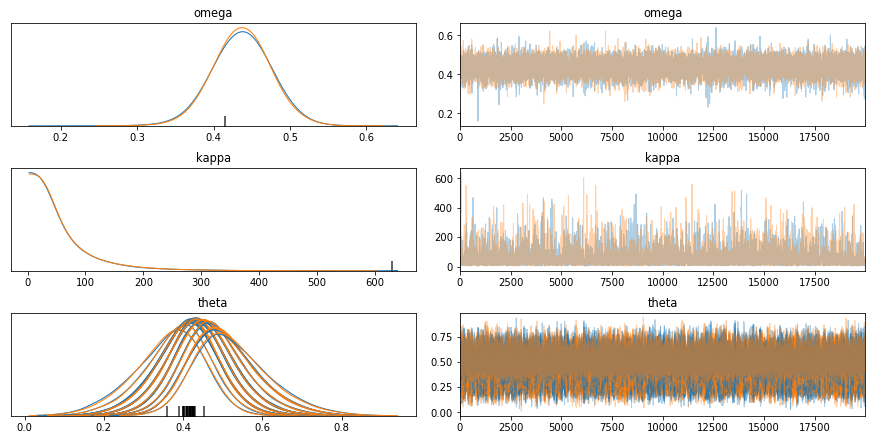

mean      sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  \
omega       0.436   0.037   0.366    0.505      0.000    0.000   11363.0   
kappa      57.915  60.737   3.644  161.074      1.179    0.932    2653.0   
theta[0]    0.361   0.087   0.193    0.519      0.001    0.001    9261.0   
theta[1]    0.385   0.083   0.223    0.540      0.001    0.001   13802.0   
theta[2]    0.408   0.080   0.251    0.556      0.001    0.000   22888.0   
theta[3]    0.407   0.079   0.255    0.558      0.001    0.000   21462.0   
theta[4]    0.408   0.080   0.250    0.553      0.001    0.000   20825.0   
theta[5]    0.408   0.080   0.254    0.560      0.001    0.000   21029.0   
theta[6]    0.408   0.080   0.254    0.561      0.001    0.000   22990.0   
theta[7]    0.408   0.080   0.254    0.561      0.001    0.000   22196.0   
theta[8]    0.407   0.080   0.247    0.551      0.001    0.000   21009.0   
theta[9]    0.408   0.080   0.249    0.554      0.001    0.000   23567.0   
theta[10]   0.431   0.079   0.274    0.577      0.000    0.000   30375.0   
theta[11]   0.431   0.079   0.272    0.577      0.000    0.000   32350.0   
theta[12]   0.431   0.078   0.283    0.583      0.000    0.000   31485.0   
theta[13]   0.431   0.079   0.276    0.578      0.000    0.000   30155.0   
theta[14]   0.431   0.078   0.285    0.584      0.000    0.000   28147.0   
theta[15]   0.454   0.079   0.301    0.606      0.000    0.000   30014.0   
theta[16]   0.454   0.079   0.301    0.606      0.000    0.000   27596.0   
theta[17]   0.454   0.080   0.303    0.608      0.000    0.000   32718.0   
theta[18]   0.455   0.079   0.308    0.611      0.000    0.000   30603.0   
theta[19]   0.454   0.079   0.307    0.607      0.000    0.000   31307.0   
theta[20]   0.454   0.080   0.304    0.610      0.000    0.000   29247.0   
theta[21]   0.454   0.079   0.305    0.608      0.000    0.000   31488.0   
theta[22]   0.478   0.082   0.329    0.640      0.001    0.000   21119.0   
theta[23]   0.477   0.083   0.330    0.646      0.001    0.000   20513.0   
theta[24]   0.501   0.087   0.345    0.672      0.001    0.001   13044.0   
theta[25]   0.501   0.087   0.340    0.667      0.001    0.001   13160.0   
theta[26]   0.501   0.088   0.341    0.672      0.001    0.001   14107.0   
theta[27]   0.524   0.094   0.364    0.710      0.001    0.001    9387.0   

            ess_sd  ess_bulk  ess_tail  r_hat  
omega      11363.0   11239.0   18162.0    1.0  
kappa       2124.0    3049.0    5164.0    1.0  
theta[0]    9261.0    9870.0   14096.0    1.0  
theta[1]   13802.0   14616.0   16499.0    1.0  
theta[2]   22888.0   23581.0   18864.0    1.0  
theta[3]   21462.0   21939.0   19232.0    1.0  
theta[4]   20825.0   21448.0   18560.0    1.0  
theta[5]   21029.0   21497.0   19767.0    1.0  
theta[6]   22990.0   23688.0   19105.0    1.0  
theta[7]   22196.0   22701.0   18623.0    1.0  
theta[8]   21009.0   21457.0   18487.0    1.0  
theta[9]   23567.0   24030.0   18274.0    1.0  
theta[10]  30375.0   30011.0   20939.0    1.0  
theta[11]  32350.0   31721.0   19336.0    1.0  
theta[12]  31485.0   31168.0   22023.0    1.0  
theta[13]  30155.0   29794.0   23058.0    1.0  
theta[14]  28147.0   27690.0   23142.0    1.0  
theta[15]  27808.0   30008.0   21558.0    1.0  
theta[16]  26128.0   27714.0   21789.0    1.0  
theta[17]  29957.0   32879.0   23442.0    1.0  
theta[18]  28087.0   30697.0   22176.0    1.0  
theta[19]  29413.0   31411.0   24022.0    1.0  
theta[20]  26851.0   29608.0   21436.0    1.0  
theta[21]  28873.0   31614.0   23229.0    1.0  
theta[22]  19075.0   22283.0   19969.0    1.0  
theta[23]  18415.0   21700.0   19744.0    1.0  
theta[24]  12035.0   14133.0   17316.0    1.0  
theta[25]  12438.0   13980.0   17327.0    1.0  
theta[26]  13047.0   15267.0   17429.0    1.0  
theta[27]   9133.0   10180.0   17250.0    1.0

In [8]:
pm.traceplot(trace, var_names=['omega', 'kappa', 'theta'], backend_kwargs=None)
plt.show()                                                                                                                                                                                                                               
az.summary (trace, var_names=['omega', 'kappa', 'theta'])

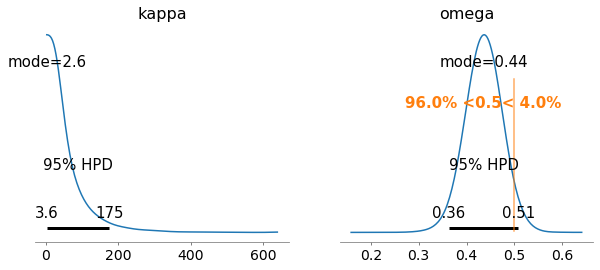

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))
pm.plot_posterior(
    trace, var_names = ["kappa", "omega"], 
    point_estimate = 'mode', 
    credible_interval = 0.95,
    ref_val = { 'omega' : [{ 'ref_val': 0.5 }] }, # a complex API to avoid giving ref_val for kappa
    ax = ax)
plt.show()

# ref_val: float or dictionary of floats
# display the percentage below and above the values in ref_val. Must be None (default), a constant, 
# a list or a dictionary like see an example below. If a list is provided, its length should match 
# the number of variables.

* Chance performance (0.5 for $\omega$) is within 95% HDI, so we cannot rule it out
* We use some helper functions to create the pair-wise comparison plots below.

In [10]:
# small helper functions for plotting  differences
def plot_diff (trace, i, j, ax):
    pm.plot_posterior(
        trace['theta'][:, i] - trace['theta'][:, j],
        point_estimate = 'mode', 
        credible_interval = 0.95,
        ref_val = 0.0,
        round_to = 3, #optional Controls formatting of floats. Defaults to 2 or the integer part, whichever is bigger.
        ax = ax)
    ax.set_xlabel(f"theta_{i} - theta_{j}")
    
def plot_one (trace, i, ax):
    pm.plot_posterior(
        trace['theta'][:, i],
        point_estimate = 'mode', 
        credible_interval = 0.95,
        ref_val = 0.5,
        round_to = 3,
        ax = ax)
    ax.set_xlabel (f"theta_{i}")

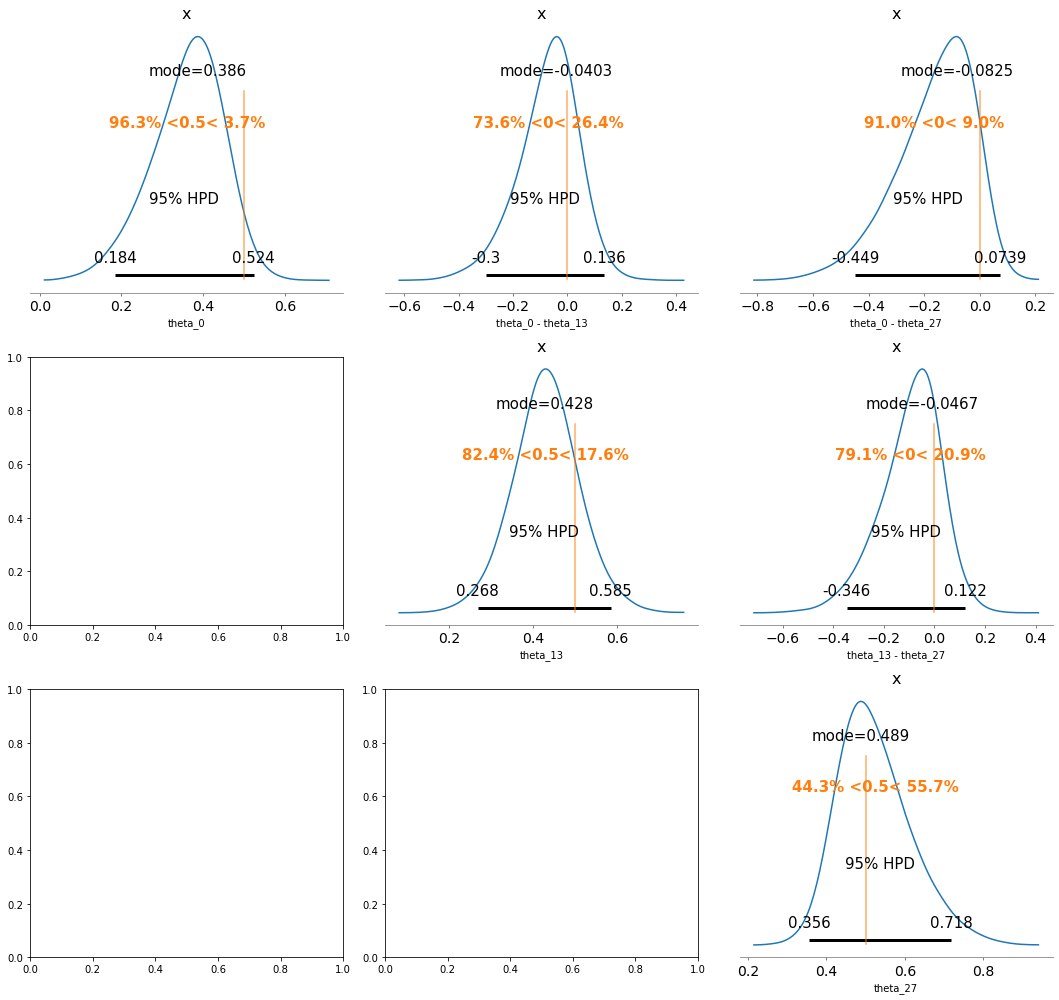

In [11]:
fig, ax = plt.subplots(3, 3, figsize=(15,14))
plot_one (trace, 0, ax[0,0])
plot_one (trace, 13, ax[1,1])
plot_one (trace, 27, ax[2,2])
plot_diff (trace, 0, 13, ax[0,1])
plot_diff (trace, 0, 27, ax[0,2])
plot_diff (trace, 13, 27, ax[1,2])
plt.tight_layout()
plt.show()

* I had some troubles plotting with pair_plot and plot_joint and the vectorized shape of theta, so I have given up.
* Subjects are sorted by modes, so that 0 had the worst performance,  and subject 27 had the best performance.
* Q. Can we conclude that the best performing subject is different from the worst performing one? TODO

# Shrinkage
* Shrinkage: reduction of variance in low level estimators towards the modes of higher-level estimator for unimodal distributions.
* For multi-modal distributions shrinkage means shifting towards higher-level models
* In either case, this is the result of all variables influencing each other in this model.

# MLE

MLE = Maximum Likelihood Estimation

* The parameter values that maximize the likelihood of data (this is *roughly* what frequntist/classical statistics does)
* Let's recall how is this computed:

\begin{align}
p ( \{y_{i\mid s}\} \mid \{\theta_s\}, \omega, \kappa ) = &\\ 
= & \prod_s \prod_{i \mid s} p (y _{i|s} | \theta_s, \omega, \kappa) \\
= & \prod_s \prod_{i \mid s} \mathrm{bern} (y _{i|s} | \theta_s) \cdot \mathrm{beta} (\theta_s \mid \omega(\kappa-2)+1, (1-\omega)(\kappa-2)+1)
\end{align}

* It turns out that the value of $\theta_s$ maximizing the likelihood is $(z_s/N_s)$ so the success rate of the subject's experiments
* This value is pulled towards $\omega$ when we want to maximize the overall model fit, dependeing on how strong is the prior.

![](fig-9.12.png)

# Exercises
* Implement the model of section 9.5 in PyMC3 (the baseball players), probably the most interesting model in the chapter, but technically not much new is happening.
* The above should be enough for the week, but Exercises 9.1 and 9.2 are also interesting, if you still have time (or you can look at them in the catch up week)